In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
import apra_pop_models.efc_2dm_embedded as emb_efc

import sys
sys.path.insert(len(sys.path), '/home/apra/Projects/embedded_howfsc/python_host')
import efc_host_utils

/home/apra/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/apra/Projects/apra-howfsc-models/apra_pop_models


/home/apra/Projects/apra-howfsc-models/apra_pop_models


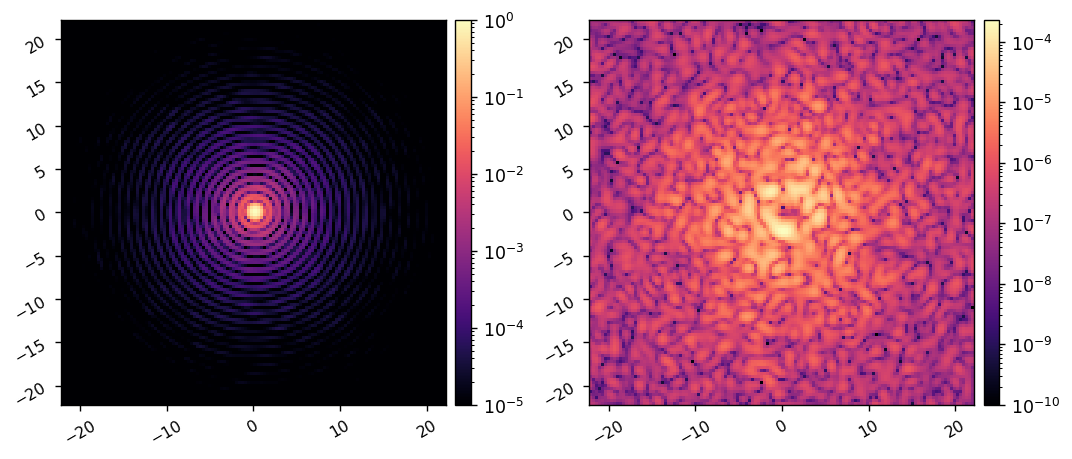

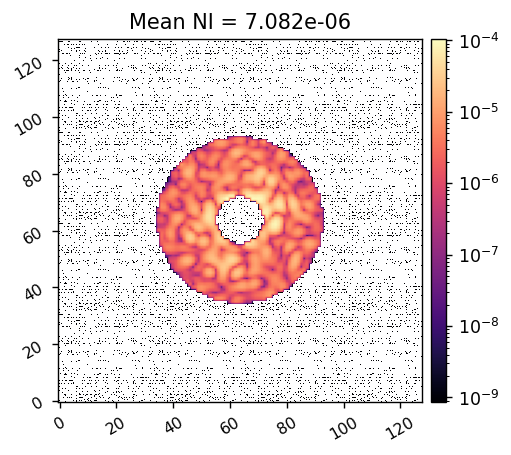

In [2]:
reload(fresnel)
reload(props)
reload(dm)

I = fresnel.CORO(
    Nact=34,
    npsf=128,
)
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref

I.use_vortex = True
ref_coro_im = I.snap()

imshow2(
    ref_psf, ref_coro_im,
    pxscl=I.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
)

iwa = 3
owa = 10
rot = 0

control_mask = efc_utils.create_annular_focal_plane_mask(
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    irad=iwa, 
    orad=owa, 
    edge=None, 
    rotation=rot,
)

ref_contrast = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {ref_contrast:.3e}', lognorm=True)

In [3]:
reload(utils)
jac = utils.load_fits('../jacobians/jac_34_2dm.fits')

In [39]:
I.reset_dms()
I.WFE.opd = xp.zeros((1000, 1000))

efc_data = {
    # 'before_images':[],
    # 'after_images':[],
    # 'before_contrasts':[],
    # 'after_contrasts':[],
    'images':[ref_coro_im],
    'contrasts':[ref_contrast],
    'time_stamps':[0],
    'actions':[],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [5]:
reload(efc_host_utils)
EC = efc_host_utils.EmbeddedController()

In [6]:
reload(emb_efc)
emb_efc.do_fun(EC.send_jacobian, I, efc_data, ensure_np_array(jac))

(None,)

In [10]:
reload(emb_efc)
emb_efc.do_fun(EC.compute_gram, I, efc_data,)
# time_taken = EC.compute_gram()

(None,)

# Run EFC without PWP

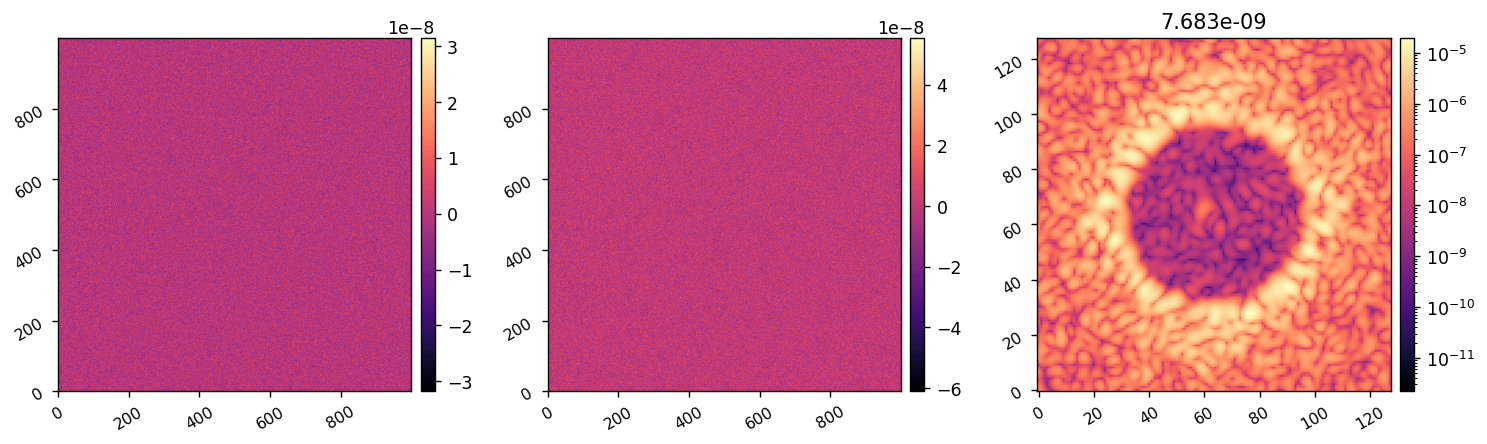

In [45]:
reload(emb_efc)
emb_efc.do_fun(EC.do_decomposition, I, efc_data, -2.5)
# time_taken = EC.do_decomposition(-2.5)

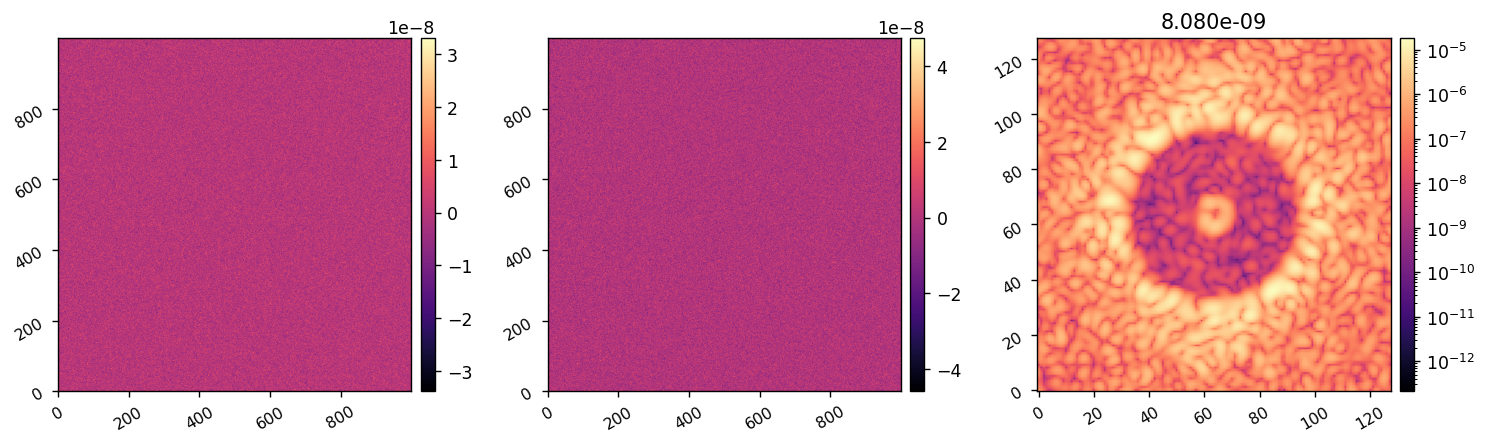

In [43]:
emb_efc.do_fun(EC.do_decomposition, I, efc_data, -5)


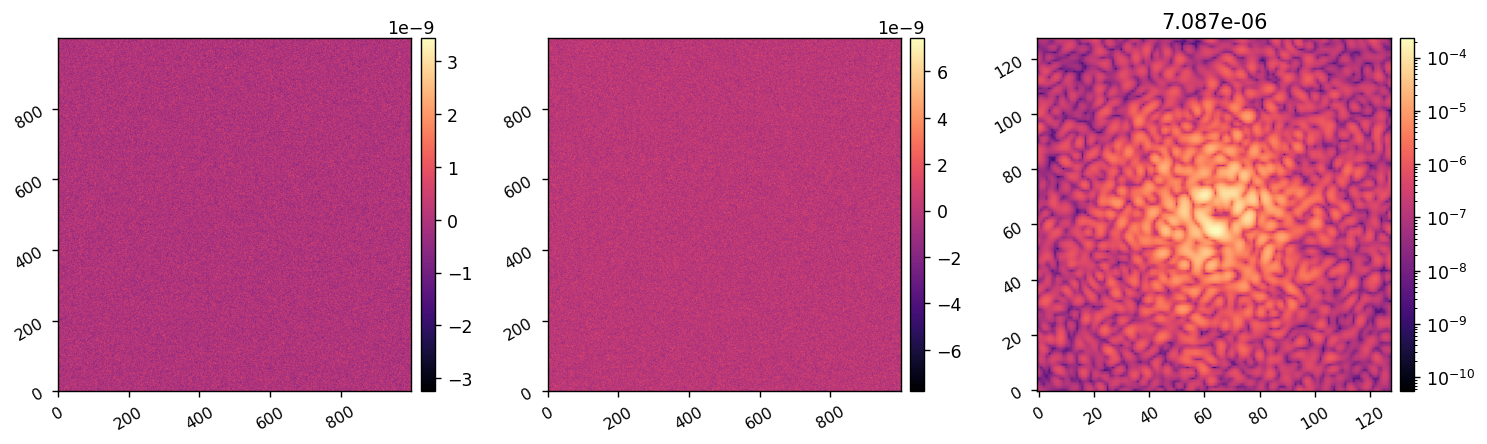

5000

In [34]:
reload(emb_efc)
emb_efc.do_fun(emb_efc.wait, I, efc_data, 5000)
# imshow2(I.WFE.opd, efc_data['images'][-1], lognorm2=1)

Beginning closed-loop EFC simulation.
	Running iteration 14/15.


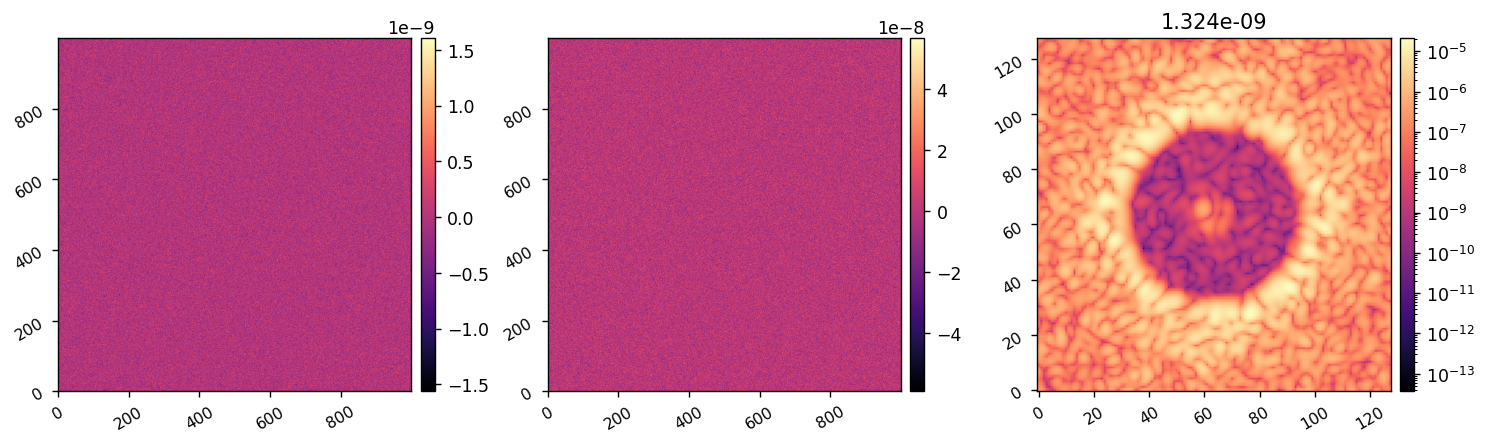

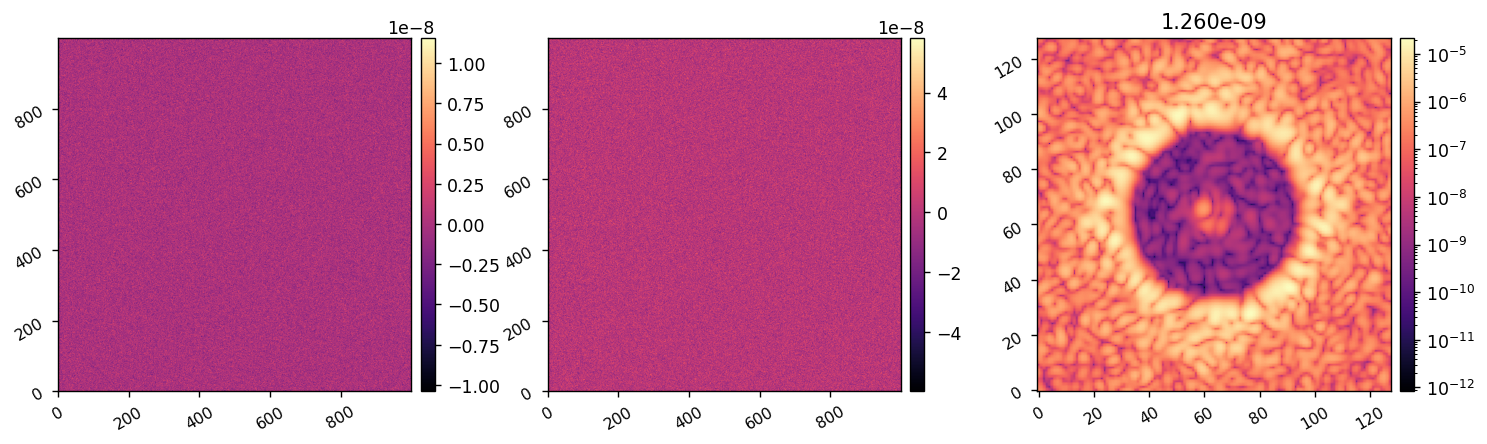

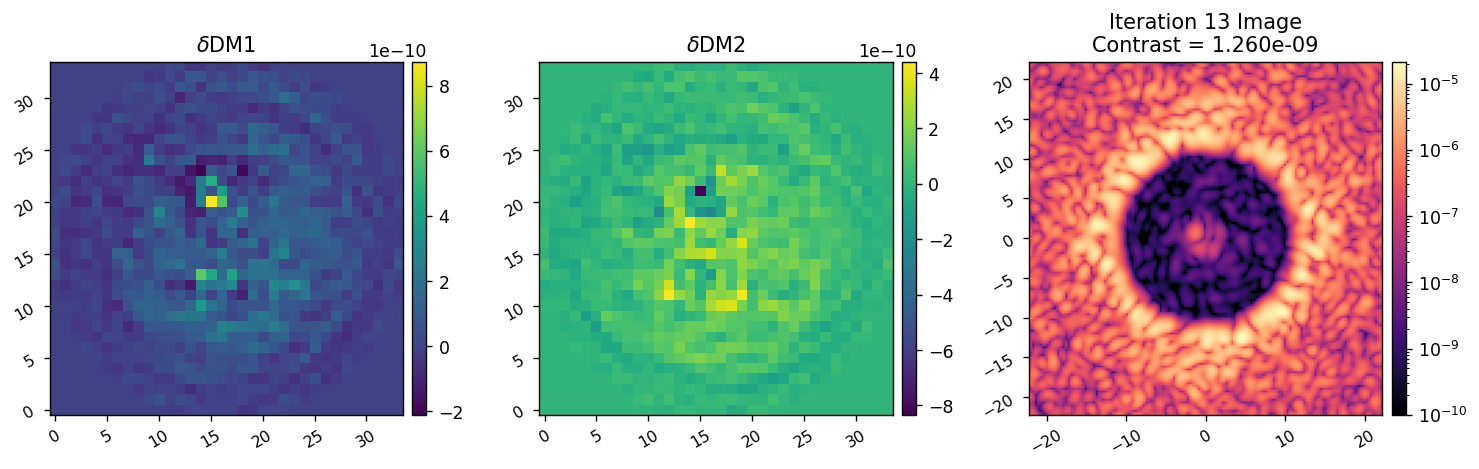

	Running iteration 15/15.


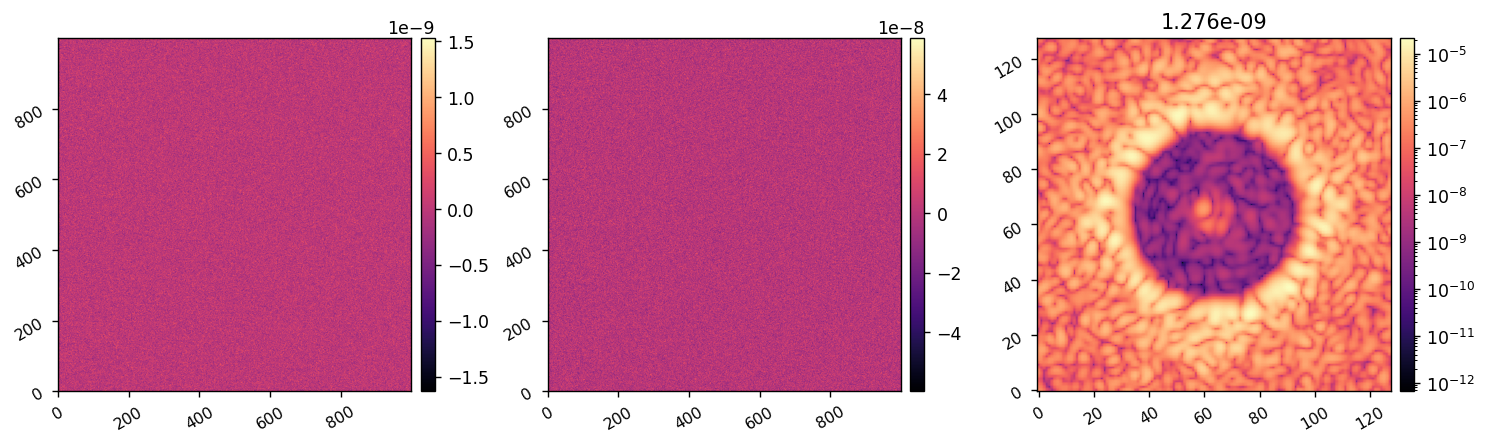

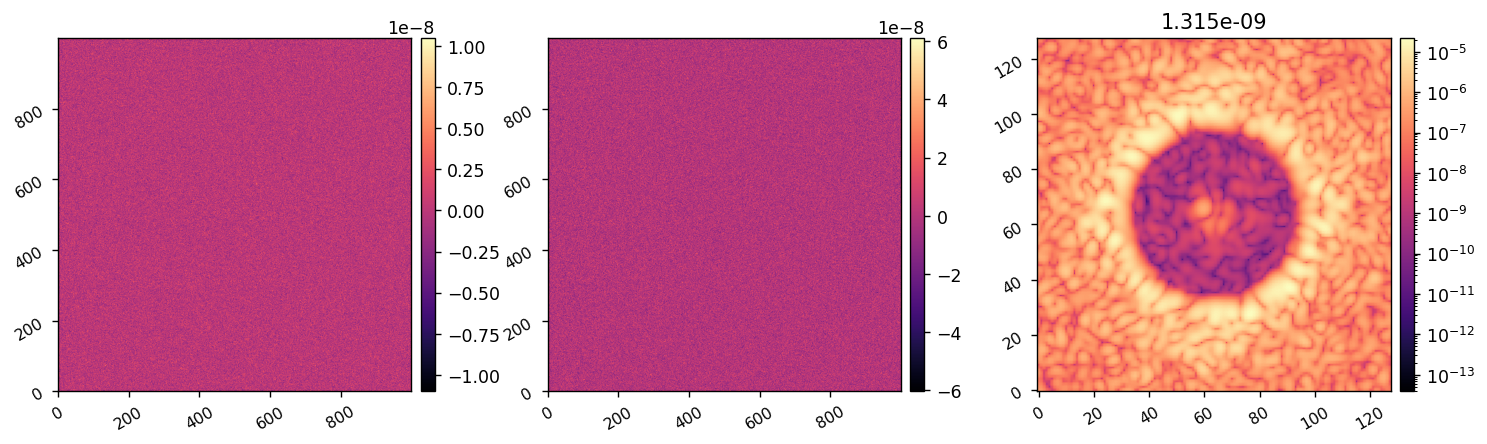

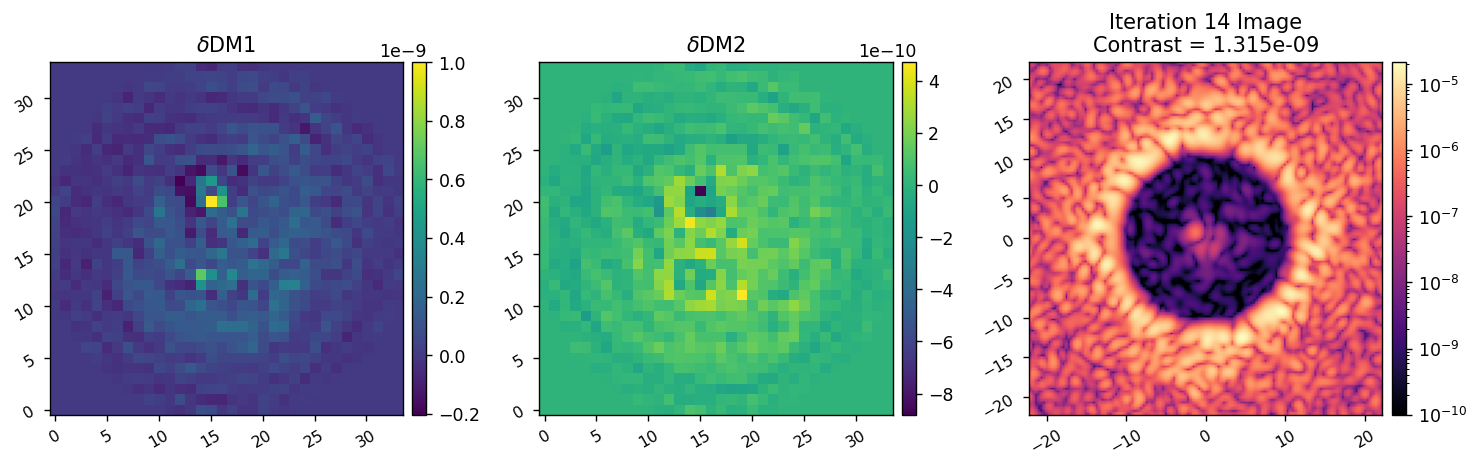

In [47]:
reload(emb_efc)

efc_data = emb_efc.run_with_decomp(
    I, 
    EC,
    efc_data, 
    # est_fun=pwp_fun, est_params=pwp_params,
    gain=1, 
    iterations=2, 
    plot_all=True,
)

In [48]:
utils.save_pickle('LS1046_efc_data_20250403.pkl', efc_data)

Saved data to:  LS1046_efc_data_20250403.pkl


In [ ]:
efc_data = utils.load_pickle()

In [26]:
EC.close()

Closing Host Utils


OSError: [Errno 9] Bad file descriptor